In [24]:
import json
import os
import pickle
import re
from tqdm import tqdm
import itertools
from __future__ import print_function
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from nltk.stem.snowball import SnowballStemmer
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt

plt.style.use('dark_background')

In [15]:
def read_data(filename):
    
    def in_washington(location):
        washington_words = ['Seattle','Washington','WA','Kirkland','Spokane',
                    'Vancouver','Bellevue','Everett','Yakima','Redmond','Kent','Tacoma']
        washington_anti = ['DC','D.C','D.C.']
        if (any(word in location for word in washington_words) and 
            not any(word in location for word in washington_anti)):
            return True
        return False
            
    def in_massachusetts(location):
        massachusetts_words = ['MA','Massachusetts','Boston','Worcester','Springfield',
                               'Lowell','Arlington','Bedford','Brockton','Quincy','Lynn',
                               'New England','Cambridge']
        massachusetts_anti = ['Ohio']
            
        if (any(word in location for word in massachusetts_words) and 
            not any(word in location for word in massachusetts_anti)):
            return True
        return False        
        
    data = []
    labels = []
    with open(filename,'r') as fp:
        tweet_count = 1348767
        for index,line in tqdm(enumerate(fp),total=tweet_count):
            entry = json.loads(line)
            location = entry['tweet']['user']['location']
            if(in_washington(location)):
                data.append(entry['tweet']['text'])
                labels.append(1)
            elif(in_massachusetts(location)):
                data.append(entry['tweet']['text'])
                labels.append(-1)
    return preprocess_tweets(data),labels

def preprocess_tweets(data):
    processed_tweets = []
    emoticons_str = r"""
        (?:
            [:=;] # Eyes
            [oO\-]? # Nose (optional)
            [D\)\]\(\]/\\OpP] # Mouth
        )"""
    html_str = r'<[^>]+>'
    url_str = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
    numbers_str = r'(?:(?:\d+,?)+(?:\.?\d+)?)'
    mention_str = r'(?:@[\w_]+)'
    hash_tag_str = r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"
    regex_str = [
        emoticons_str, html_str,mention_str,
        url_str, numbers_str,hash_tag_str,r'(?:[\w_]+)',r"(?:[a-z][a-z'\-_]+[a-z])",
    ]

    delete_str = [
        emoticons_str, html_str,mention_str,
        url_str, numbers_str, r'RT'
    ]

    tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
    emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
    delete_re = re.compile(r'('+'|'.join(delete_str)+')', re.VERBOSE | re.IGNORECASE)

    def tokenize(s):
        return tokens_re.findall(s)

    def preprocess(s, lowercase=True):
        tokens = tokenize(s)
        if lowercase:
            tokens = [token.lower() for token in tokens if not delete_re.search(token)]
        return ' '.join(tokens)

    for tweet in data:
        processed_tweets.append(preprocess(tweet))
    return processed_tweets

def init_params():
    stemmer = SnowballStemmer('english')
    analyzer = CountVectorizer().build_analyzer()
    vectorizer = CountVectorizer(stop_words='english',
                                 min_df=2, max_df=0.95, analyzer=stem_words)
    tfidf_transformer = TfidfTransformer(norm='l2', sublinear_tf=True)
    return [stemmer,analyzer,vectorizer,tfidf_transformer]

def stem_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

def get_tfidf(vectorizer,tfidf_transformer,data,isTraining=True):
    if(isTraining):
        count_data = vectorizer.fit_transform(data)
        tfidf_data = tfidf_transformer.fit_transform(count_data)
    else:
        count_data = vectorizer.transform(data)
        tfidf_data = tfidf_transformer.transform(count_data)        
    return tfidf_data

In [16]:
def get_data(filename=None,dataset='train',precomputed=True):
    if(filename is None):
        precomputed = True
    if(not precomputed):
        if not os.path.exists(os.path.join('data',dataset,'part2')):
            os.makedirs(os.path.join('data',dataset,'part2'))
        tweets,labels = read_data(os.path.join('data',dataset,filename))
        name = filename[:filename.index('.')]+'.pkl'
        pickle_filename = os.path.join('data',dataset,'part2',name)
        with(open(pickle_filename,'wb')) as fp:
            pickle.dump([tweets,labels],fp,protocol=2)
    else:
        name = filename[:filename.index('.')]+'.pkl'
        pickle_filename = os.path.join('data',dataset,'part2',name)
        with(open(pickle_filename,'rb')) as fp:
            tweets,labels = pickle.load(fp)
    return tweets,labels

print('Loading #superbowl tweets')
tweets,labels = get_data('tweets_#superbowl.txt',precomputed=True)
print('Number of tweets =',len(tweets))

Loading #superbowl tweets


100%|███████████████████████████████████████████████| 1348767/1348767 [11:59<00:00, 1874.04it/s]


Number of tweets = 54663


In [17]:
load_tfidf_data = True
target_names = ['Washington','Massachusetts']
pickleFile = os.path.join('data','train','part2','tfidf.pkl')

if(not load_tfidf_data):
    print('Computing TF-IDF matrix')
    stemmer,analyzer,vectorizer,tfidf_transformer = init_params()
    tweets_train,tweets_test,train_labels,test_labels = train_test_split(tweets,labels,
                                                                     test_size=0.15,
                                                                     random_state=42)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    tweets_train = get_tfidf(vectorizer,tfidf_transformer,tweets_train)
    tweets_test = get_tfidf(vectorizer,tfidf_transformer,tweets_test,isTraining=False)
 
    with open(pickleFile,'wb') as fp:
        pickle.dump({'tweets_train':tweets_train,'tweets_test':tweets_test,
                     'train_labels':train_labels,'test_labels':test_labels},fp)
else:
    with open(pickleFile,'rb') as fp:
        pickle_data = pickle.load(fp)
        tweets_train = pickle_data['tweets_train']
        tweets_test = pickle_data['tweets_test']
        train_labels = pickle_data['train_labels']
        test_labels = pickle_data['test_labels']
        
print('Shape of Training Data =', tweets_train.shape)
print('Shape of Testing Data =', tweets_test.shape)
print('# of Washington Labels in training=', sum(train_labels==1))
print('# of Massachusetts Labels in training=', sum(train_labels==-1))
print('# of Washington Labels in testing=', sum(test_labels==1))
print('# of Massachusetts Labels in testing=', sum(test_labels==-1))

Computing TF-IDF matrix
Shape of Training Data = (46463, 9383)
Shape of Testing Data = (8200, 9383)
# of Washington Labels in training= 23372
# of Massachusetts Labels in training= 23091
# of Washington Labels in testing= 4089
# of Massachusetts Labels in testing= 4111


In [18]:
def get_lsi(data,dim,lsi=None,train=True):
    if(train):
        lsi = TruncatedSVD(n_components=dim, n_iter=7, random_state=42)
        lsi_data = lsi.fit_transform(data)
    else:
        lsi_data = lsi.transform(data)
    return lsi,lsi_data

def get_nmf(data,dim,nmf=None,train=True):
    if(train):
        nmf = NMF(n_components=dim, init='random', random_state=42)
        nmf_data = nmf.fit_transform(data)
    else:
        nmf_data = nmf.transform(data)
    return nmf,nmf_data

def reduced_dimension(dim_reduce,train_data=None,test_data=None,precomputed=False,dim=100):
    pickleFile = os.path.join('data','train','part2',dim_reduce+'.pkl')
    if(precomputed):
        with open(pickleFile,'rb') as fp:
            dim_reduce_dict = pickle.load(fp)
        model = dim_reduce_dict['model']
        train_data = dim_reduce_dict['train']
        test_data = dim_reduce_dict['test']
    else:
        if(dim_reduce == 'lsi'):
            method = get_lsi
        else:
            method = get_nmf
        model,train_data = method(train_data,dim)
        _,test_data = method(test_data,dim,model,train=False)
        with open(pickleFile,'wb') as fp:
            pickle.dump({'model':model,'train':train_data,'test':test_data},fp)
    return train_data,test_data

#### Visualization of Separability

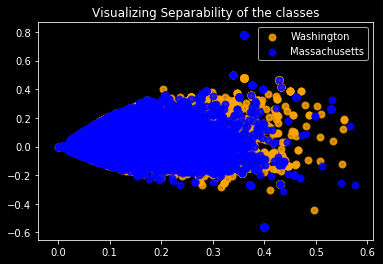

In [19]:
def visualize(data,labels,target_names):
    #Visualization
    colors = ['orange', 'blue']
    for color, i, target_name in zip(colors, [1,-1], target_names):
        plt.scatter(data[labels == i, 0], data[labels == i, 1], color=color, alpha=.8, lw=2,
                    label=target_name)
    plt.legend(loc='best', labels=target_names)
    plt.title('Visualizing Separability of the classes')
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_roc_curve(fpr,tpr,algo):
    roc_auc = metrics.auc(fpr,tpr)
    fig=plt.figure(figsize=(8,8))
    plt.title(''.join(['ROC - ',algo]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()
    
target_names = ['Washington','Massachusetts']
_,visualize_data = get_lsi(tweets_train,2)    
visualize(visualize_data,train_labels,target_names)

In [20]:
X_train,X_test = reduced_dimension('lsi',tweets_train,tweets_test,precomputed=True,dim=100)

In [21]:
def classify(model,X_train,X_test,y_train,y_test,classifier):
    target_names = ['Washington','Massachusetts']
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of model =',metrics.accuracy_score(y_pred,y_test))
    print('Precision of model =',metrics.precision_score(y_pred,y_test))
    print('Recall of model =',metrics.recall_score(y_pred,y_test))
    cfm = metrics.confusion_matrix(y_pred,y_test)
    plot_confusion_matrix(cfm,target_names)
    y_pred = model.predict_proba(X_test)
    fpr,tpr,_ = metrics.roc_curve(y_test, y_pred[:,1])
    plot_roc_curve(fpr,tpr,classifier)

#### Naive Bayes - Bernoulli

Accuracy of model = 0.667804878049
Precision of model = 0.647591098068
Recall of model = 0.673619944035


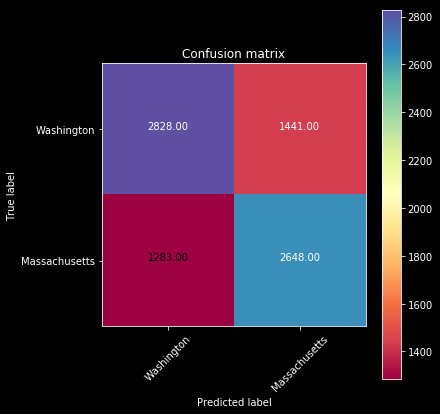

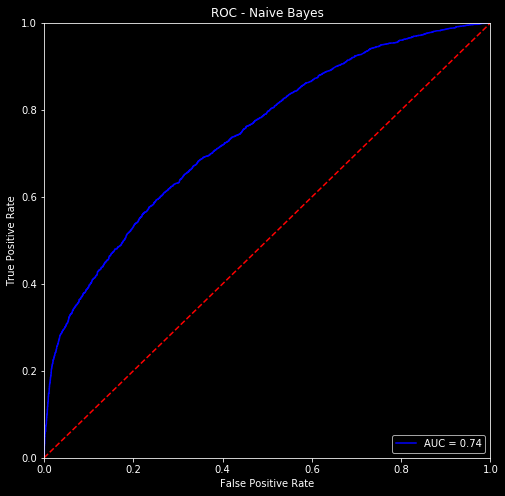

In [22]:
classify(BernoulliNB(),X_train,X_test,train_labels,test_labels,'Naive Bayes')

#### SVM

Accuracy of model = 0.701097560976
Precision of model = 0.469797016385
Recall of model = 0.871597096189


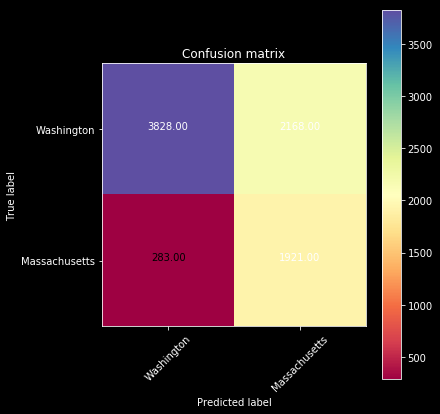

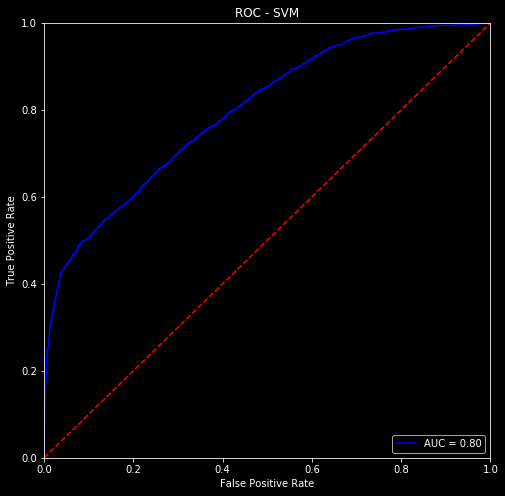

In [30]:
classify(svm.SVC(C=10,probability=True),X_train,X_test,train_labels,test_labels,'SVM')

#### AdaBoost

Accuracy of model = 0.68756097561
Precision of model = 0.602592320861
Recall of model = 0.724492796236


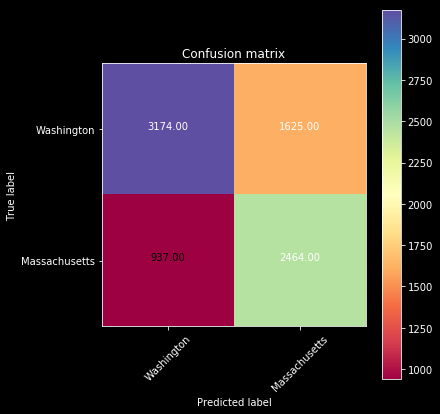

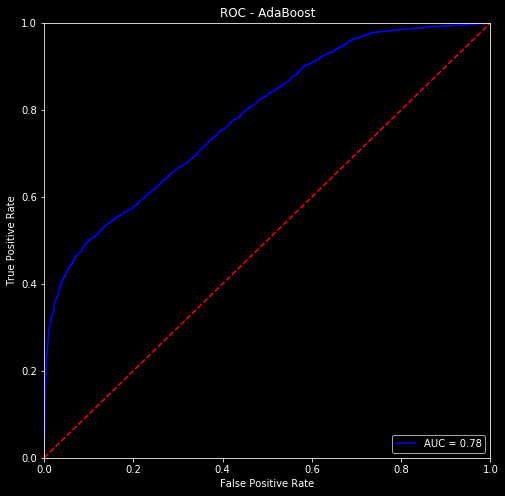

In [25]:
classify(AdaBoostClassifier(), X_train,X_test,train_labels,test_labels,'AdaBoost')

#### Random Forest Classifier

Accuracy of model = 0.691951219512
Precision of model = 0.475421863536
Recall of model = 0.836129032258


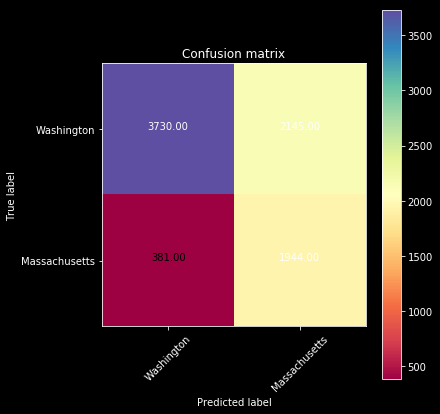

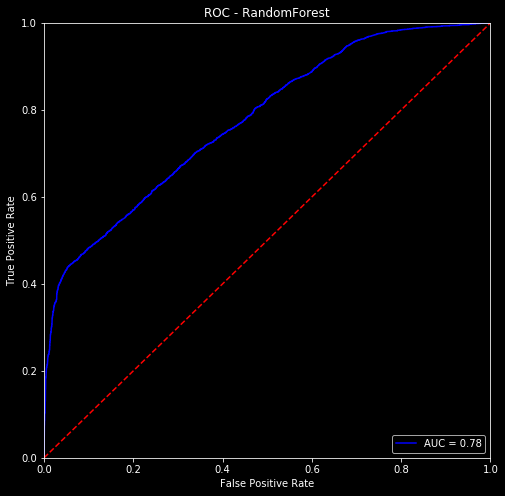

In [26]:
classify(RandomForestClassifier(max_depth=5, n_estimators=50)
         ,X_train,X_test,train_labels,test_labels,'RandomForest')

#### Neural Network

Accuracy of model = 0.706341463415
Precision of model = 0.62313524089
Recall of model = 0.746120058565


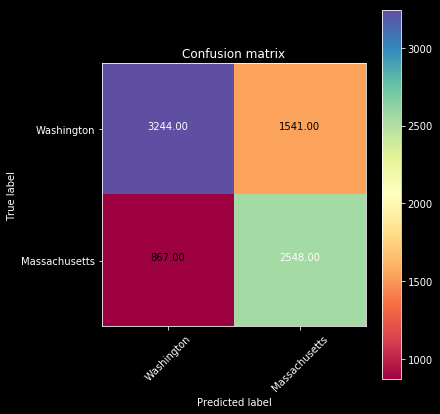

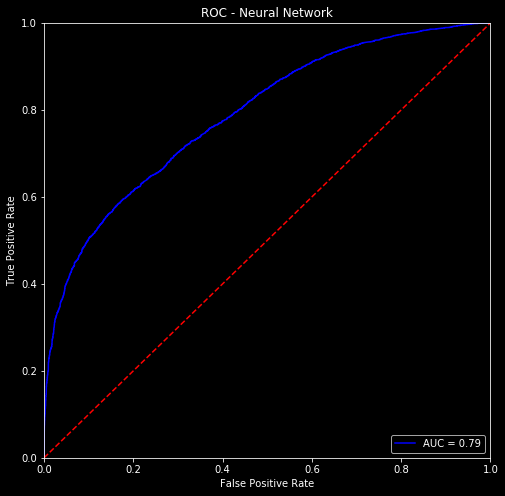

In [28]:
classify(MLPClassifier(hidden_layer_sizes=[64,64],activation='relu',batch_size=128),
         X_train,X_test,train_labels,test_labels,'Neural Network')

#### Logistic Regression

Accuracy of model = 0.710487804878
Precision of model = 0.565663976522
Recall of model = 0.79457231192


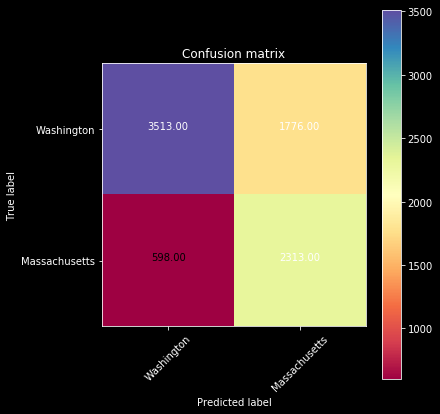

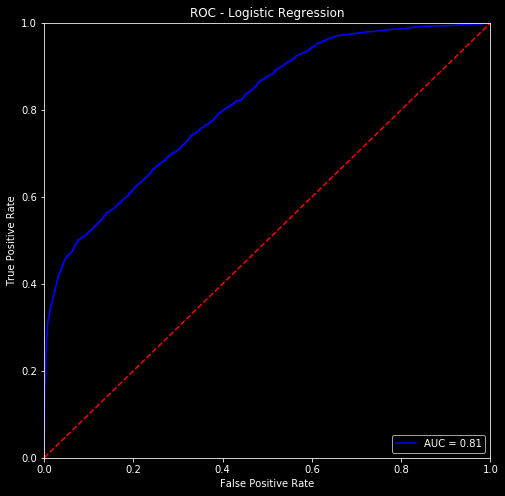

In [29]:
classify(LogisticRegression(C=10, penalty='l2'),X_train,X_test,train_labels,test_labels,'Logistic Regression')

#### SVM (Do not execute! - training time too long)

# Tuning hyper-parameters for accuracy - lsi
Best parameters set found on development set:
{'kernel': 'rbf', 'C': 10}
Grid scores on development set:
0.540 (+/-0.000) for {'kernel': 'rbf', 'C': 0.01}
0.643 (+/-0.004) for {'kernel': 'linear', 'C': 0.01}
0.540 (+/-0.000) for {'kernel': 'poly', 'C': 0.01}
0.642 (+/-0.004) for {'kernel': 'rbf', 'C': 0.1}
0.683 (+/-0.005) for {'kernel': 'linear', 'C': 0.1}
0.540 (+/-0.000) for {'kernel': 'poly', 'C': 0.1}
0.683 (+/-0.005) for {'kernel': 'rbf', 'C': 1}
0.687 (+/-0.006) for {'kernel': 'linear', 'C': 1}
0.540 (+/-0.000) for {'kernel': 'poly', 'C': 1}
0.688 (+/-0.005) for {'kernel': 'rbf', 'C': 10}
0.687 (+/-0.006) for {'kernel': 'linear', 'C': 10}
0.540 (+/-0.000) for {'kernel': 'poly', 'C': 10}
Detailed classification report:
Accuracy of model = 0.688025774118
Precision of model = 0.8465085639
Recall of model = 0.668053028334


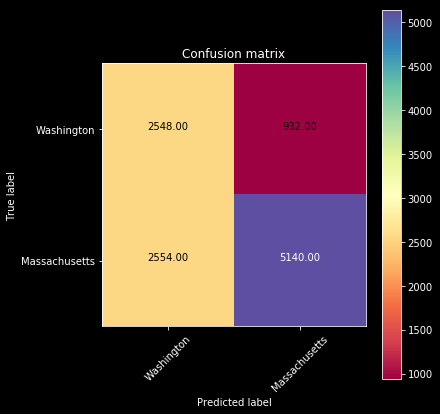

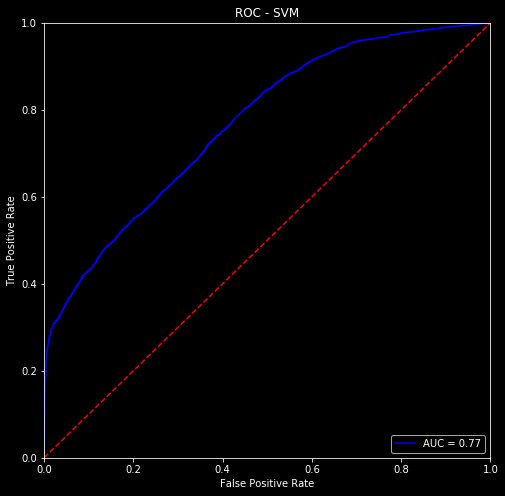

In [11]:
def svm_function(X_train,X_test,y_train,y_test,target_names,typ):
    tuned_parameters = [{'kernel': ['rbf','linear','poly']}]
    scores = ['accuracy']
    for score in scores:
        print("# Tuning hyper-parameters for {0} - {1}".format(score,typ))
        clf = GridSearchCV(svm.SVC(C=10,probability=True), tuned_parameters, cv=1,
                           scoring=score, n_jobs=5)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print("Grid scores on development set:")
        for params, mean_score, scores in clf.grid_scores_:
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean_score, scores.std() * 2, params))
        print("Detailed classification report:")
        y_pred = clf.predict(X_test)
        print('Accuracy of model =',metrics.accuracy_score(y_pred,y_test))
        print('Precision of model =',metrics.precision_score(y_pred,y_test))
        print('Recall of model =',metrics.recall_score(y_pred,y_test))
        cfm = metrics.confusion_matrix(y_pred,y_test)
        plot_confusion_matrix(cfm,target_names)
        y_preds = clf.predict_proba(X_test)
        fpr,tpr,_ = metrics.roc_curve(y_test, y_preds[:,1])
        plot_roc_curve(fpr,tpr,'SVM')

svm_function(lsi_train,lsi_test,train_labels,test_labels,target_names,'lsi')